In [1]:
from models.detae_allhist_glm import DetAE_AllHist_GLM, GLM_Encoder

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 500
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 10000
epoch_no = 3300
layer_no = 3

In [4]:
Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
#train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = DetAE_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)
encoder = GLM_Encoder(C_syn_e, C_syn_i, T_no, device)

dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.0025)
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.0025)

decoder.to(device).float()
encoder.to(device).float()

print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

160
135


In [ ]:
t = torch.arange(T_no+1).to(device)
t_tau = t / 5
kern = t_tau * torch.exp(-t_tau)
kern = torch.flip(kern, [0]).reshape(1,-1).repeat(sub_no,1).unsqueeze(1)

test_kern = t_tau * torch.exp(-t_tau)

bce_criterion = nn.BCELoss()
prior = torch.ones(batch_size, sub_no-1).to(device)*0.01

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    dec_optimizer.zero_grad()
    enc_optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    Z_hid, P_hid = encoder(batch_Z, batch_E_neural, batch_I_neural)
    
    Z_enc = torch.zeros(batch_size, sub_no).to(device)
    Z_enc[:,0] = Z_enc[:,0] + batch_Z
    Z_enc[:,1:] = Z_enc[:,1:] + Z_hid
    
    Z_pred, P_pred = decoder.train_forward(batch_E_neural, batch_I_neural, Z_enc)
    
    filt_enc_Z = F.conv1d(Z_enc.T.unsqueeze(0), kern, padding=T_no//2, groups=sub_no).squeeze(0).T
    filt_pred_Z = F.conv1d(Z_pred.T.unsqueeze(0), kern, padding=T_no//2, groups=sub_no).squeeze(0).T 
        
    #mse_loss = torch.mean((filt_enc_Z[:,:].detach() - filt_pred_Z[:,:])**2)
    mse_loss = torch.mean((filt_enc_Z[:,1:].detach() - filt_pred_Z[:,1:])**2)
    out_loss = torch.mean((filt_enc_Z[:,0].detach() - filt_pred_Z[:,0])**2)
    bce_loss = bce_criterion(P_pred , Z_enc.detach())
    prior_loss = bce_criterion(P_hid, prior)
    loss = mse_loss + out_loss + prior_loss
    #loss = bce_loss + prior_loss
    
    loss.backward()
    dec_optimizer.step()
    enc_optimizer.step()
    
    if i%500 == 499:
        decoder.eval()
        #encoder.eval()
        test_Z_hid, test_P_hid = encoder(Z_test, test_E_neural, test_I_neural)
        test_Z_pred, test_P_pred, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
        
        test_Z_in = torch.hstack((Z_test.reshape(-1,1), test_Z_hid))
        
        filt_test_Z = F.conv1d(test_Z_in.T.unsqueeze(0), kern, padding=T_no//2, groups=sub_no).squeeze(0).T
        filt_test_pred_Z = F.conv1d(test_Z_pred.T.unsqueeze(0), kern, padding=T_no//2, groups=sub_no).squeeze(0).T
         
        test_loss = torch.mean((filt_test_Z[:,0] - filt_test_pred_Z[:,0])**2).item()
        
        print(i, test_loss, bce_loss.item(), out_loss.item(), torch.mean(test_P_pred).item(), torch.sum(test_Z_in).item())


<ipython-input-6-dcdc4a3e4f46>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


499 0.0010651993798092008 0.4594917297363281 0.0014015865745022893 0.37063390016555786 42.0


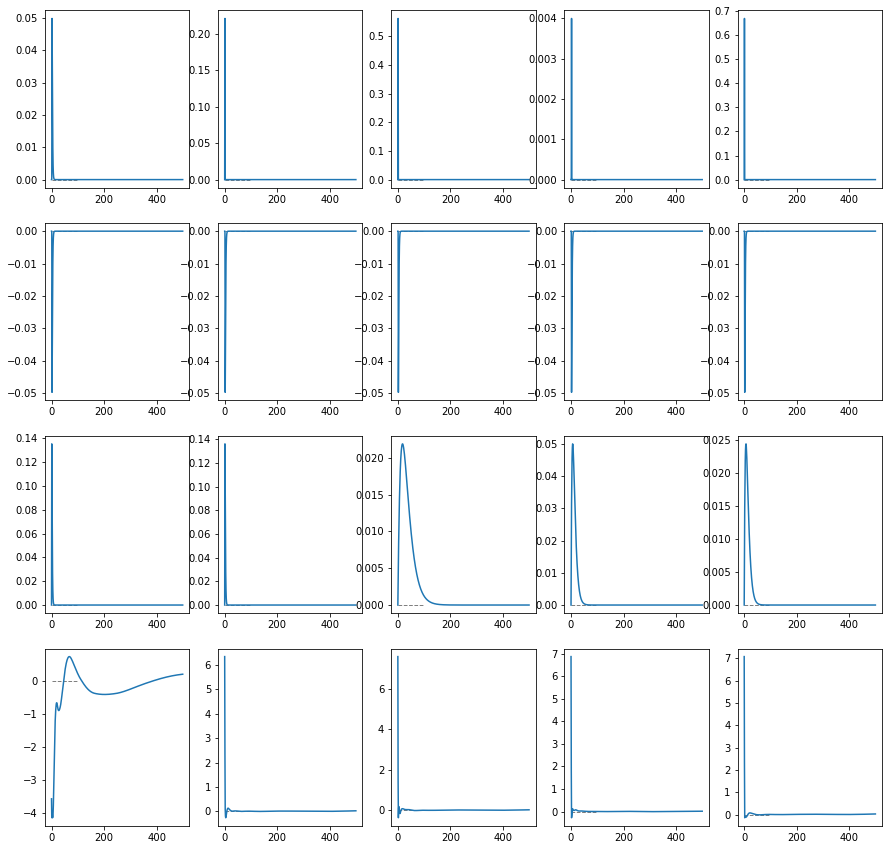

In [7]:
sub_no = 5
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(15,15))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:750])
        axs[row,col].hlines(y=0,xmin=0,xmax=100, color="gray",linewidth=1,linestyle="--")

tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>)


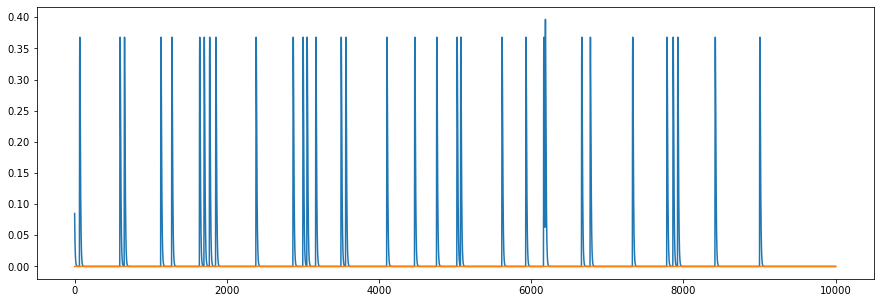

In [13]:
plt.figure(figsize=(15,5))
plt.plot(filt_enc_Z.cpu().detach().numpy()[18000:28000,0])
plt.plot(filt_pred_Z.cpu().detach().numpy()[18000:28000,0])

print(torch.mean((filt_pred_Z[:,1] - filt_enc_Z[:,1])**2))

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)


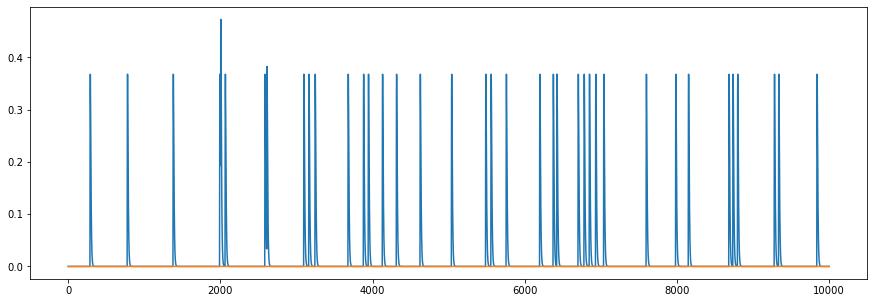

In [9]:
plt.figure(figsize=(15,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[16000:26000,0])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[16000:26000,0])
print(torch.mean((filt_test_Z[:,0] - filt_test_pred_Z[:,0])**2))

In [10]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Tau_syn tensor([[ 0.0000,  0.0000],
        [-2.1962,  0.0000],
        [-2.2403,  0.0000],
        [-2.1120,  0.0000],
        [-2.3601,  0.0000]], device='cuda:0')
Delta_syn tensor([[ 0.0000,  0.0000],
        [-0.3567,  0.0000],
        [-0.2504,  0.0000],
        [ 0.0116,  0.0000],
        [-0.0819,  0.0000]], device='cuda:0')
W_syn tensor([[-2.0000, -2.0000],
        [ 0.6763, -2.0000],
        [ 0.4089, -2.0000],
        [ 0.3344, -2.0000],
        [ 0.6415, -2.0000]], device='cuda:0')
Tau_spk tensor([0.0000, 0.1354, 3.4019, 2.0850, 2.8908], device='cuda:0')
Delta_spk tensor([0., 0., 0., 0., 0.], device='cuda:0')
W_spk tensor([-1.0000, -1.2241, -3.1216, -2.0971, -3.2944], device='cuda:0')
W_hist tensor([[-2.5250e+00, -2.4335e+00, -1.9924e+00, -2.0651e+00, -2.1277e+00,
         -2.3205e+00, -1.5856e+00, -3.3648e-01, -1.3715e-01, -1.0473e+00,
          4.8860e-01,  4.5569e-01, -4.0852e-02, -1.9825e-01, -2.2386e-01,
         -1.9293e-01,  2.1940e-01],
        [ 5.2067e+00,  3.0135e

In [11]:
print(torch.sum(test_Z_pred, 0))

tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SumBackward1>)


In [12]:
print(torch.sum(test_Z_in, 0))

tensor([  42., 7223., 6322., 7642., 6598.], device='cuda:0',
       grad_fn=<SumBackward1>)
